In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from scipy.stats import gaussian_kde
from scipy.stats import percentileofscore

from matplotlib import pyplot as plt

# Body spec

In [2]:
variables_to_use = ['pitching_max_hss', 'jump_height_(imp-mom)_[cm]_mean_cmj',
'lower-limb_stiffness_[n/m]_mean_cmj', 'peak_power_[w]_mean_cmj',
'peak_power_/_bm_[w/kg]_mean_cmj',
'eccentric_braking_rfd_[n/s]_mean_cmj',
'eccentric_duration_[ms]_mean_cmj', 'concentric_duration_[ms]_mean_cmj',
'rsi-modified_[m/s]_mean_cmj', 'countermovement_depth_[cm]_mean_cmj',
'cmj_stiffness_asymmetry_[%_l,r]_mean_cmj',
'eccentric_deceleration_impulse_(asymmetry)_[%_l,r]_mean_cmj',
'p1_concentric_impulse_asymmetry_[%_l,r]_mean_cmj',
'p2_concentric_impulse_asymmetry_[%_l,r]_mean_cmj',
'concentric_peak_force_[n]_mean_cmj',
'eccentric_peak_force_[n]_mean_cmj',
'minimum_eccentric_force_[n]_mean_cmj',
'jump_height_(imp-mom)_[cm]_mean_sj', 'peak_power_[w]_mean_sj',
'peak_power_/_bm_[w/kg]_mean_sj',
'p1_concentric_impulse_asymmetry_[%_l,r]_mean_sj',
'p2_concentric_impulse_asymmetry_[%_l,r]_mean_sj',
'peak_vertical_force_[n]_max_imtp',
'net_peak_vertical_force_[n]_max_imtp', 'force_at_100ms_[n]_max_imtp',
'force_at_150ms_[n]_max_imtp', 'force_at_200ms_[n]_max_imtp',
'best_active_stiffness_[n/m]_mean_ht',
'best_jump_height_(flight_time)_[cm]_mean_ht',
'best_rsi_(flight/contact_time)_mean_ht',
'best_rsi_(jump_height/contact_time)_[m/s]_mean_ht',
'peak_takeoff_force_[n]_mean_pp', 'peak_eccentric_force_[n]_mean_pp',
'peak_takeoff_force_asymmetry_[%_l,r]_mean_pp',
'peak_eccentric_force_asymmetry_[%_l,r]_mean_pp', 
'TSpineRomR','TSpineRomL', 'TSpineRomMax',
'ShoulderERL', 'ShoulderERR', 'ShoulderERMax', 'ShoulderIRL','ShoulderIRR', 'ShoulderIRMax',
'ShoulderArcL', 'ShoulderArcR',
'relative_strength', 'body_weight_[lbs]']

In [3]:
def remove_outliers_and_report(df, variables_to_use):
    df_cleaned = df.copy()
    outlier_percentages = {}
    total = len(df)
    
    for var in variables_to_use:
        Q1 = df_cleaned[var].quantile(0.25)
        Q3 = df_cleaned[var].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Calculate the number of outliers
        outliers = df_cleaned[(df_cleaned[var] < lower_bound) | (df_cleaned[var] > upper_bound)]
        num_outliers = len(outliers)
        
        # Remove the outliers
        df_cleaned = df_cleaned[(df_cleaned[var] >= lower_bound) & (df_cleaned[var] <= upper_bound)]
    
    return df_cleaned, num_outliers / total

In [4]:
df = pd.read_csv('high_performance/data/hp_obp.csv')
df = df.dropna(subset=['pitch_speed_mph'])
df = df[df['pitch_speed_mph'] >= 20] # drop some errors

# don't know if lefty or righty QQ
# add TSpineRomMax, ShoulderERMax, ShoudlerIRMax
df['TSpineRomMax'] = df[['TSpineRomR', 'TSpineRomL']].max(axis=1)
df['ShoulderERMax'] = df[['ShoulderERL', 'ShoulderERR']].max(axis=1)
df['ShoulderIRMax'] = df[['ShoulderIRL', 'ShoulderIRR']].max(axis=1)
df['ShoulderArcL'] = df['ShoulderIRL'] + df['ShoulderERL']
df['ShoulderArcR'] = df['ShoulderIRR'] + df['ShoulderERR']

# remove outliers
#df, outlier_percentages = remove_outliers_and_report(df, variables_to_use)
#print("Outlier Percentages:", outlier_percentages)

# we don't care lefty or righty
for var in df.columns:
    if '[%_l,r]' in var:
        df[var] = df[var].abs()

df_pro = df[df['playing_level'] == 'Pro']
df_college = df[df['playing_level'] == 'College']
df_high_school = df[df['playing_level'] == 'High School']

In [5]:
df_90 = df[df['pitch_speed_mph'] >= 90]
df_80 = df[(df['pitch_speed_mph'] >= 80) & (df['pitch_speed_mph'] < 90)]
df_70 = df[(df['pitch_speed_mph'] >= 70) & (df['pitch_speed_mph'] < 80)]
df_60 = df[df['pitch_speed_mph'] < 70]

## Basic Info Histogram

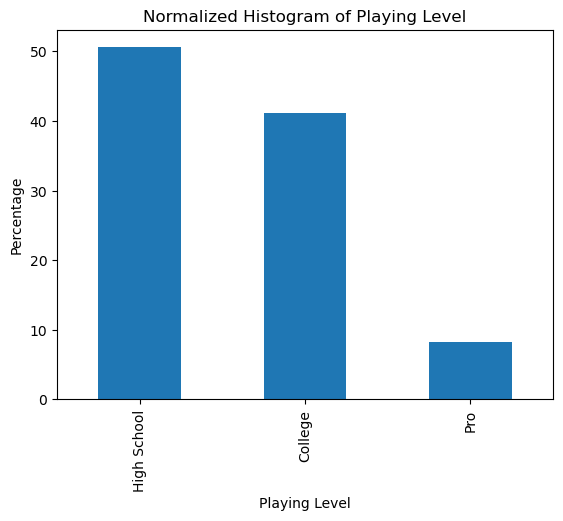

In [34]:
df['playing_level'].value_counts(normalize=True).mul(100).plot(kind='bar')
plt.xlabel('Playing Level')
plt.ylabel('Percentage')
plt.title('Normalized Histogram of Playing Level')
plt.show()

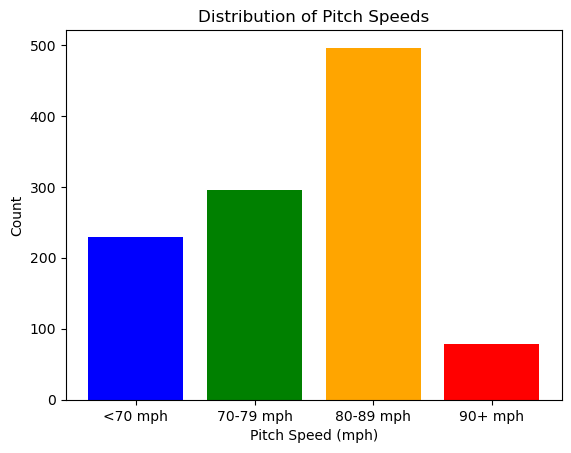

In [35]:
counts = [len(df_60), len(df_70), len(df_80), len(df_90)]
labels = ['<70 mph', '70-79 mph', '80-89 mph', '90+ mph']
plt.bar(labels, counts, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Pitch Speed (mph)')
plt.ylabel('Count')
plt.title('Distribution of Pitch Speeds')
plt.show()

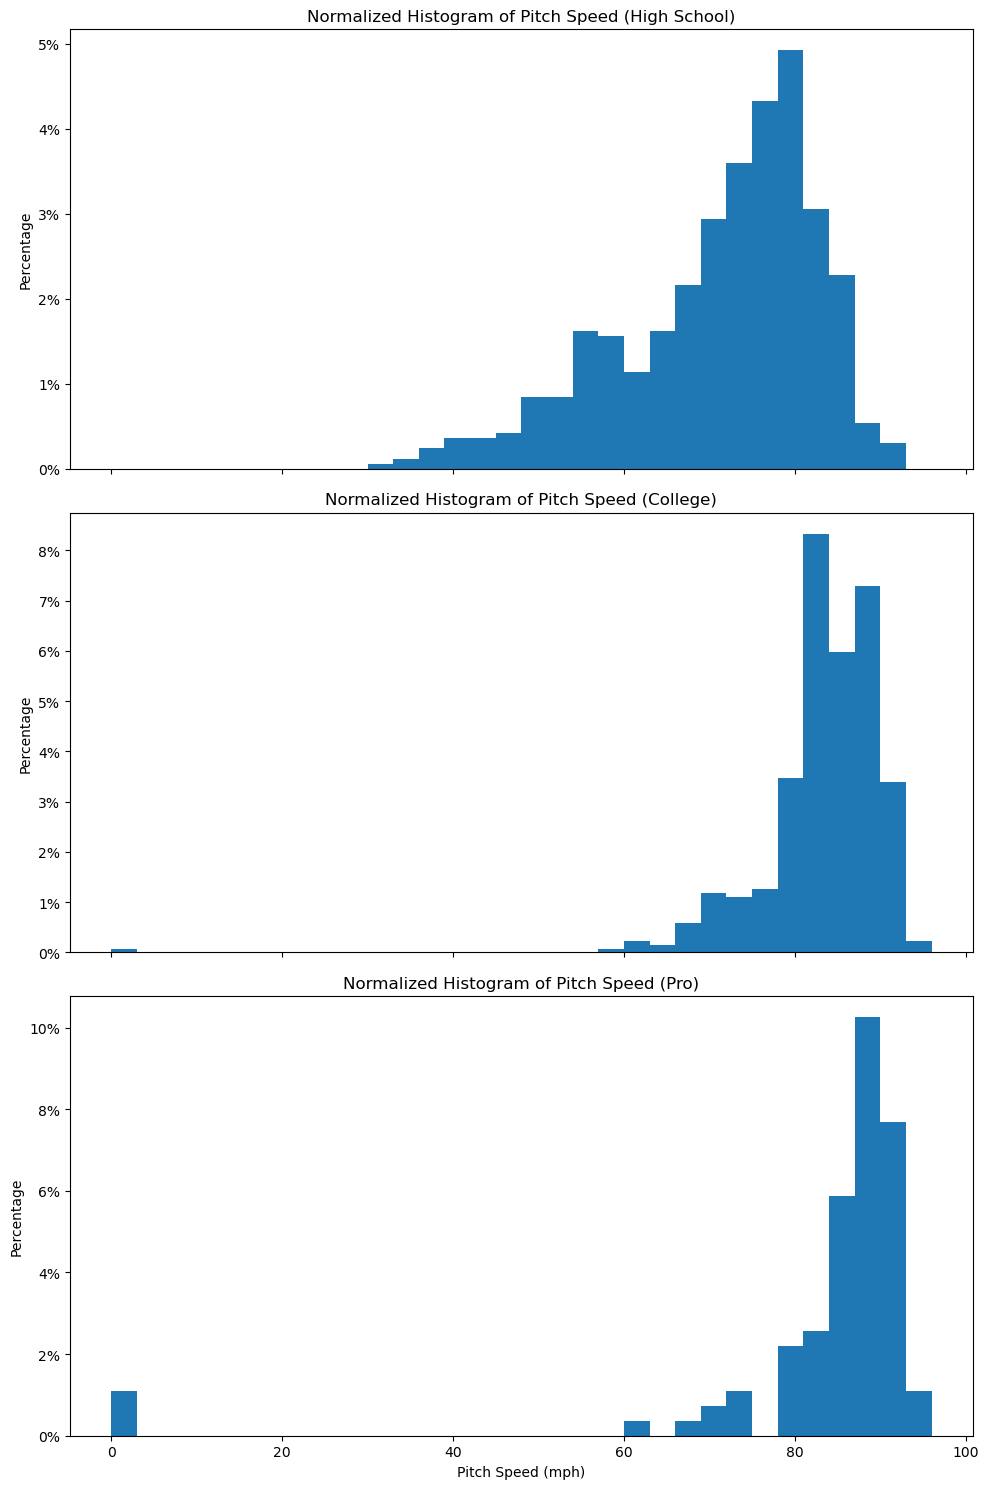

In [36]:
# Define the bins
bins = range(int(df['pitch_speed_mph'].min()), int(df['pitch_speed_mph'].max()) + 3, 3)

# Create a figure and axes
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 15))

# Plot for High School
df_high_school['pitch_speed_mph'].plot(kind='hist', bins=bins, density=True, ax=axs[0])
axs[0].set_title('Normalized Histogram of Pitch Speed (High School)')
axs[0].set_ylabel('Percentage')
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Plot for College
df_college['pitch_speed_mph'].plot(kind='hist', bins=bins, density=True, ax=axs[1])
axs[1].set_title('Normalized Histogram of Pitch Speed (College)')
axs[1].set_ylabel('Percentage')
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Plot for Pro
df_pro['pitch_speed_mph'].plot(kind='hist', bins=bins, density=True, ax=axs[2])
axs[2].set_title('Normalized Histogram of Pitch Speed (Pro)')
axs[2].set_xlabel('Pitch Speed (mph)')
axs[2].set_ylabel('Percentage')
axs[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Show the plots
plt.tight_layout()
plt.show()

## HSS

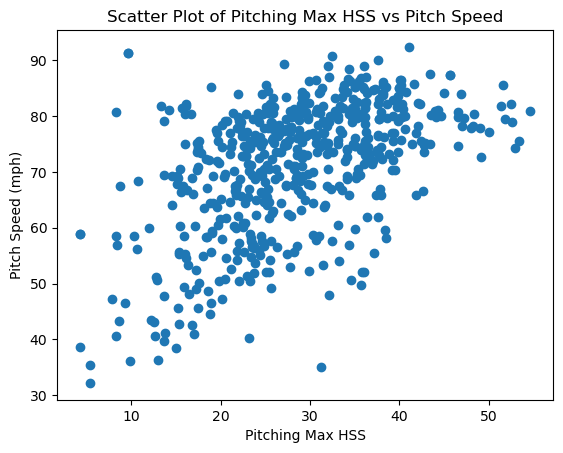

In [37]:
# Plot the scatter plot
plt.scatter(df_high_school['pitching_max_hss'], df_high_school['pitch_speed_mph'])
plt.xlabel('Pitching Max HSS')
plt.ylabel('Pitch Speed (mph)')
plt.title('Scatter Plot of Pitching Max HSS vs Pitch Speed')
plt.show()

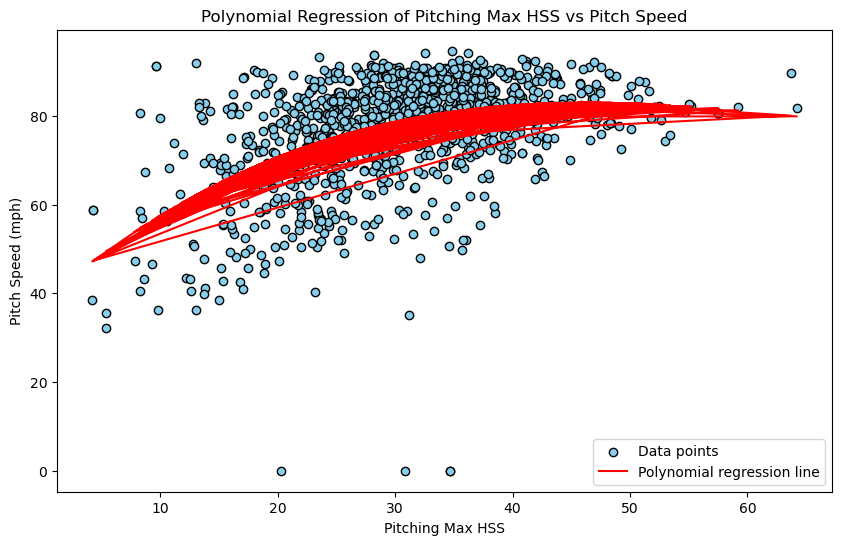

In [38]:
# Extract the features and target variable
X = df[['pitching_max_hss']]
y = df['pitch_speed_mph']

# Create polynomial features
poly = PolynomialFeatures(degree=3)  # You can change the degree to 3 for cubic regression
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict values
y_poly_pred = model.predict(X_poly)

# Plot the scatter plot and the polynomial regression line
plt.figure(figsize=(10, 6))
plt.scatter(df['pitching_max_hss'], df['pitch_speed_mph'], color='skyblue', edgecolor='black', label='Data points')
plt.plot(df['pitching_max_hss'], y_poly_pred, color='red', label='Polynomial regression line')
plt.xlabel('Pitching Max HSS')
plt.ylabel('Pitch Speed (mph)')
plt.title('Polynomial Regression of Pitching Max HSS vs Pitch Speed')
plt.legend()
plt.show()

## Correlations

### Group by playing level

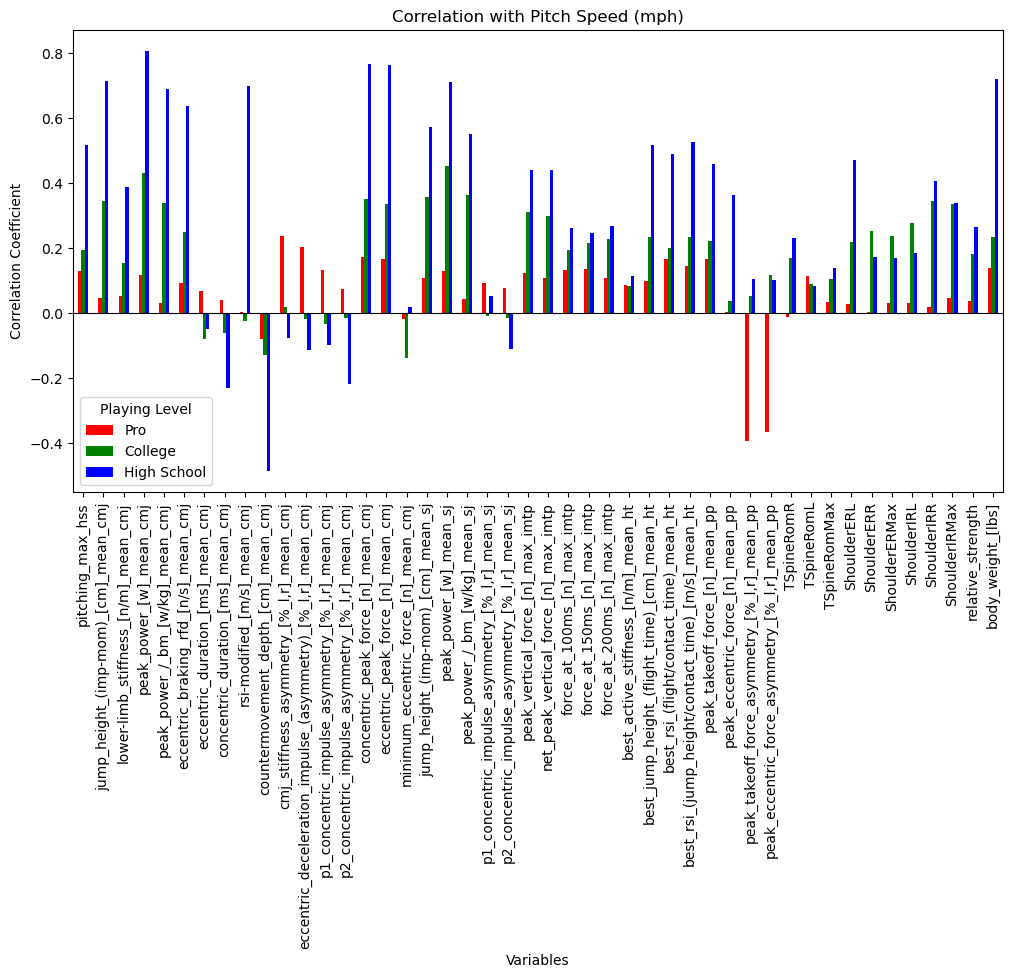

In [39]:
# Calculate the correlation coefficients with 'pitch_speed_mph' for the specified variables
correlations_pro = df_pro[variables_to_use + ['pitch_speed_mph']].corr()['pitch_speed_mph'].drop('pitch_speed_mph')
correlations_college = df_college[variables_to_use + ['pitch_speed_mph']].corr()['pitch_speed_mph'].drop('pitch_speed_mph')
correlations_high = df_high_school[variables_to_use + ['pitch_speed_mph']].corr()['pitch_speed_mph'].drop('pitch_speed_mph')

# Combine the correlations into a single DataFrame
correlations = pd.DataFrame({
    'Pro': correlations_pro,
    'College': correlations_college,
    'High School': correlations_high
})

fig, ax = plt.figure(figsize=(12, 6)), plt.gca()
correlations.plot(kind='bar', color=['red', 'green', 'blue'], ax=ax)
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation with Pitch Speed (mph)')
plt.axhline(0, color='black', linewidth=0.8)
plt.legend(title='Playing Level')
plt.savefig('fig.png')
plt.show()
# Pro's don't just use one part of their body, everything is important

In [40]:
correlations['Pro'].sort_values(ascending=False)[:5]

cmj_stiffness_asymmetry_[%_l,r]_mean_cmj                       0.237360
eccentric_deceleration_impulse_(asymmetry)_[%_l,r]_mean_cmj    0.205268
concentric_peak_force_[n]_mean_cmj                             0.174633
peak_takeoff_force_[n]_mean_pp                                 0.168426
eccentric_peak_force_[n]_mean_cmj                              0.167042
Name: Pro, dtype: float64

In [41]:
correlations['College'].sort_values(ascending=False)[:5]

peak_power_[w]_mean_sj                0.452032
peak_power_[w]_mean_cmj               0.430340
peak_power_/_bm_[w/kg]_mean_sj        0.364645
jump_height_(imp-mom)_[cm]_mean_sj    0.356693
concentric_peak_force_[n]_mean_cmj    0.351840
Name: College, dtype: float64

In [42]:
correlations['High School'].sort_values(ascending=False)[:5]

peak_power_[w]_mean_cmj                0.807310
concentric_peak_force_[n]_mean_cmj     0.766178
eccentric_peak_force_[n]_mean_cmj      0.765452
body_weight_[lbs]                      0.720437
jump_height_(imp-mom)_[cm]_mean_cmj    0.715494
Name: High School, dtype: float64

### Group by speed

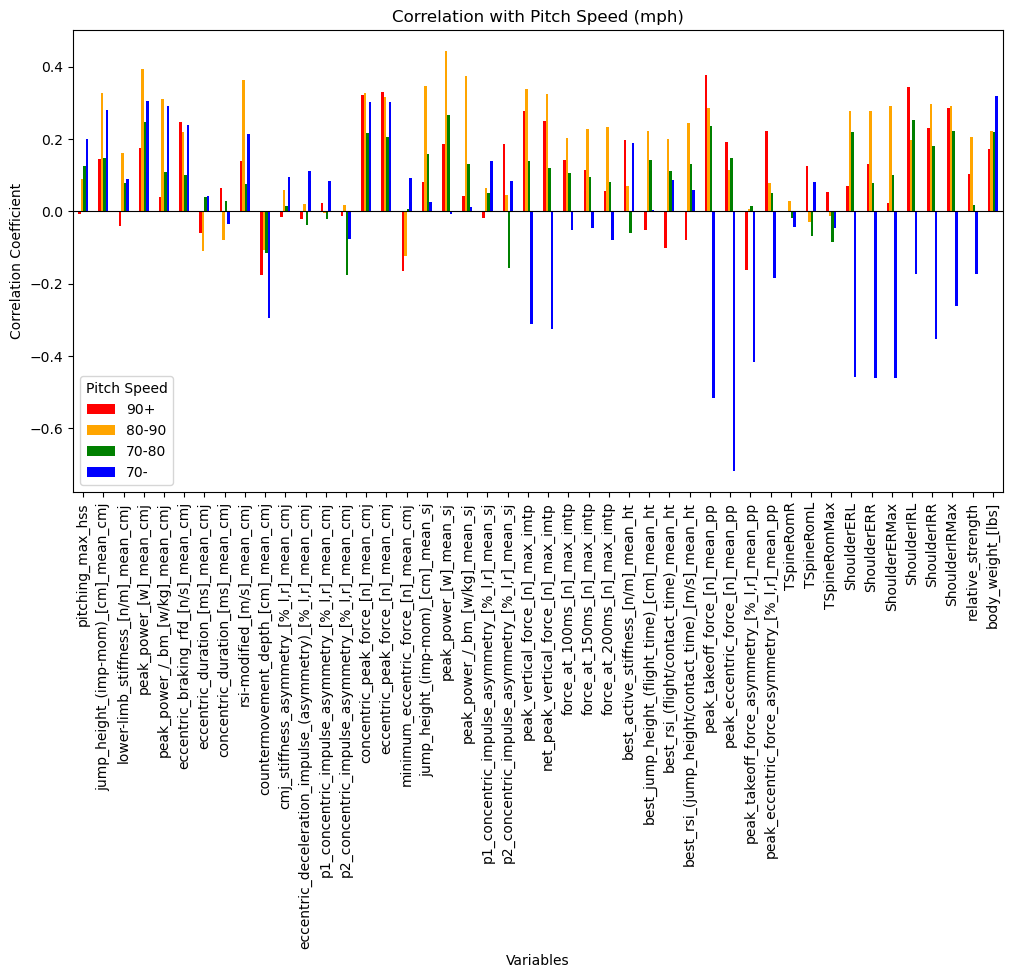

In [43]:
# Calculate the correlation coefficients with 'pitch_speed_mph' for the specified variables
correlations_90 = df_90[variables_to_use + ['pitch_speed_mph']].corr()['pitch_speed_mph'].drop('pitch_speed_mph')
correlations_80 = df_80[variables_to_use + ['pitch_speed_mph']].corr()['pitch_speed_mph'].drop('pitch_speed_mph')
correlations_70 = df_70[variables_to_use + ['pitch_speed_mph']].corr()['pitch_speed_mph'].drop('pitch_speed_mph')
correlations_60 = df_60[variables_to_use + ['pitch_speed_mph']].corr()['pitch_speed_mph'].drop('pitch_speed_mph')

# Combine the correlations into a single DataFrame
correlations = pd.DataFrame({
    '90+': correlations_90,
    '80-90': correlations_80,
    '70-80': correlations_70,
    '70-': correlations_60,
})

fig, ax = plt.figure(figsize=(12, 6)), plt.gca()
correlations.plot(kind='bar', color=['red', 'orange', 'green', 'blue'], ax=ax)
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation with Pitch Speed (mph)')
plt.axhline(0, color='black', linewidth=0.8)
plt.legend(title='Pitch Speed')
plt.savefig('fig.png')
plt.show()

In [44]:
correlations['90+'].sort_values(ascending=False)[:5]

peak_takeoff_force_[n]_mean_pp        0.377393
ShoulderIRL                           0.344554
eccentric_peak_force_[n]_mean_cmj     0.328930
concentric_peak_force_[n]_mean_cmj    0.321782
ShoulderIRMax                         0.284857
Name: 90+, dtype: float64

In [45]:
correlations['80-90'].sort_values(ascending=False)[:5]

peak_power_[w]_mean_sj                0.443216
peak_power_[w]_mean_cmj               0.392775
peak_power_/_bm_[w/kg]_mean_sj        0.374012
rsi-modified_[m/s]_mean_cmj           0.362868
jump_height_(imp-mom)_[cm]_mean_sj    0.347827
Name: 80-90, dtype: float64

In [46]:
correlations['70-80'].sort_values(ascending=False)[:5]

peak_power_[w]_mean_sj            0.267749
ShoulderIRL                       0.252136
peak_power_[w]_mean_cmj           0.247249
peak_takeoff_force_[n]_mean_pp    0.235789
ShoulderIRMax                     0.222011
Name: 70-80, dtype: float64

In [47]:
correlations['70-'].sort_values(ascending=False)[:5]

body_weight_[lbs]                     0.320086
peak_power_[w]_mean_cmj               0.304212
concentric_peak_force_[n]_mean_cmj    0.303843
eccentric_peak_force_[n]_mean_cmj     0.303462
peak_power_/_bm_[w/kg]_mean_cmj       0.290153
Name: 70-, dtype: float64

## Probability

#### $P(HSS >= h | speed>=s)$

In [48]:
def find_prob_hss_given_speed(df, h, s):
    df_speed = df[df['pitch_speed_mph'] >= s]
    count_hss_given_speed = len(df_speed[df_speed['pitching_max_hss'] >= h])
    total_speed = len(df_speed)
    return 0 if total_speed == 0  else count_hss_given_speed / total_speed

In [49]:
find_prob_hss_given_speed(df, 40, 90)

0.16666666666666666

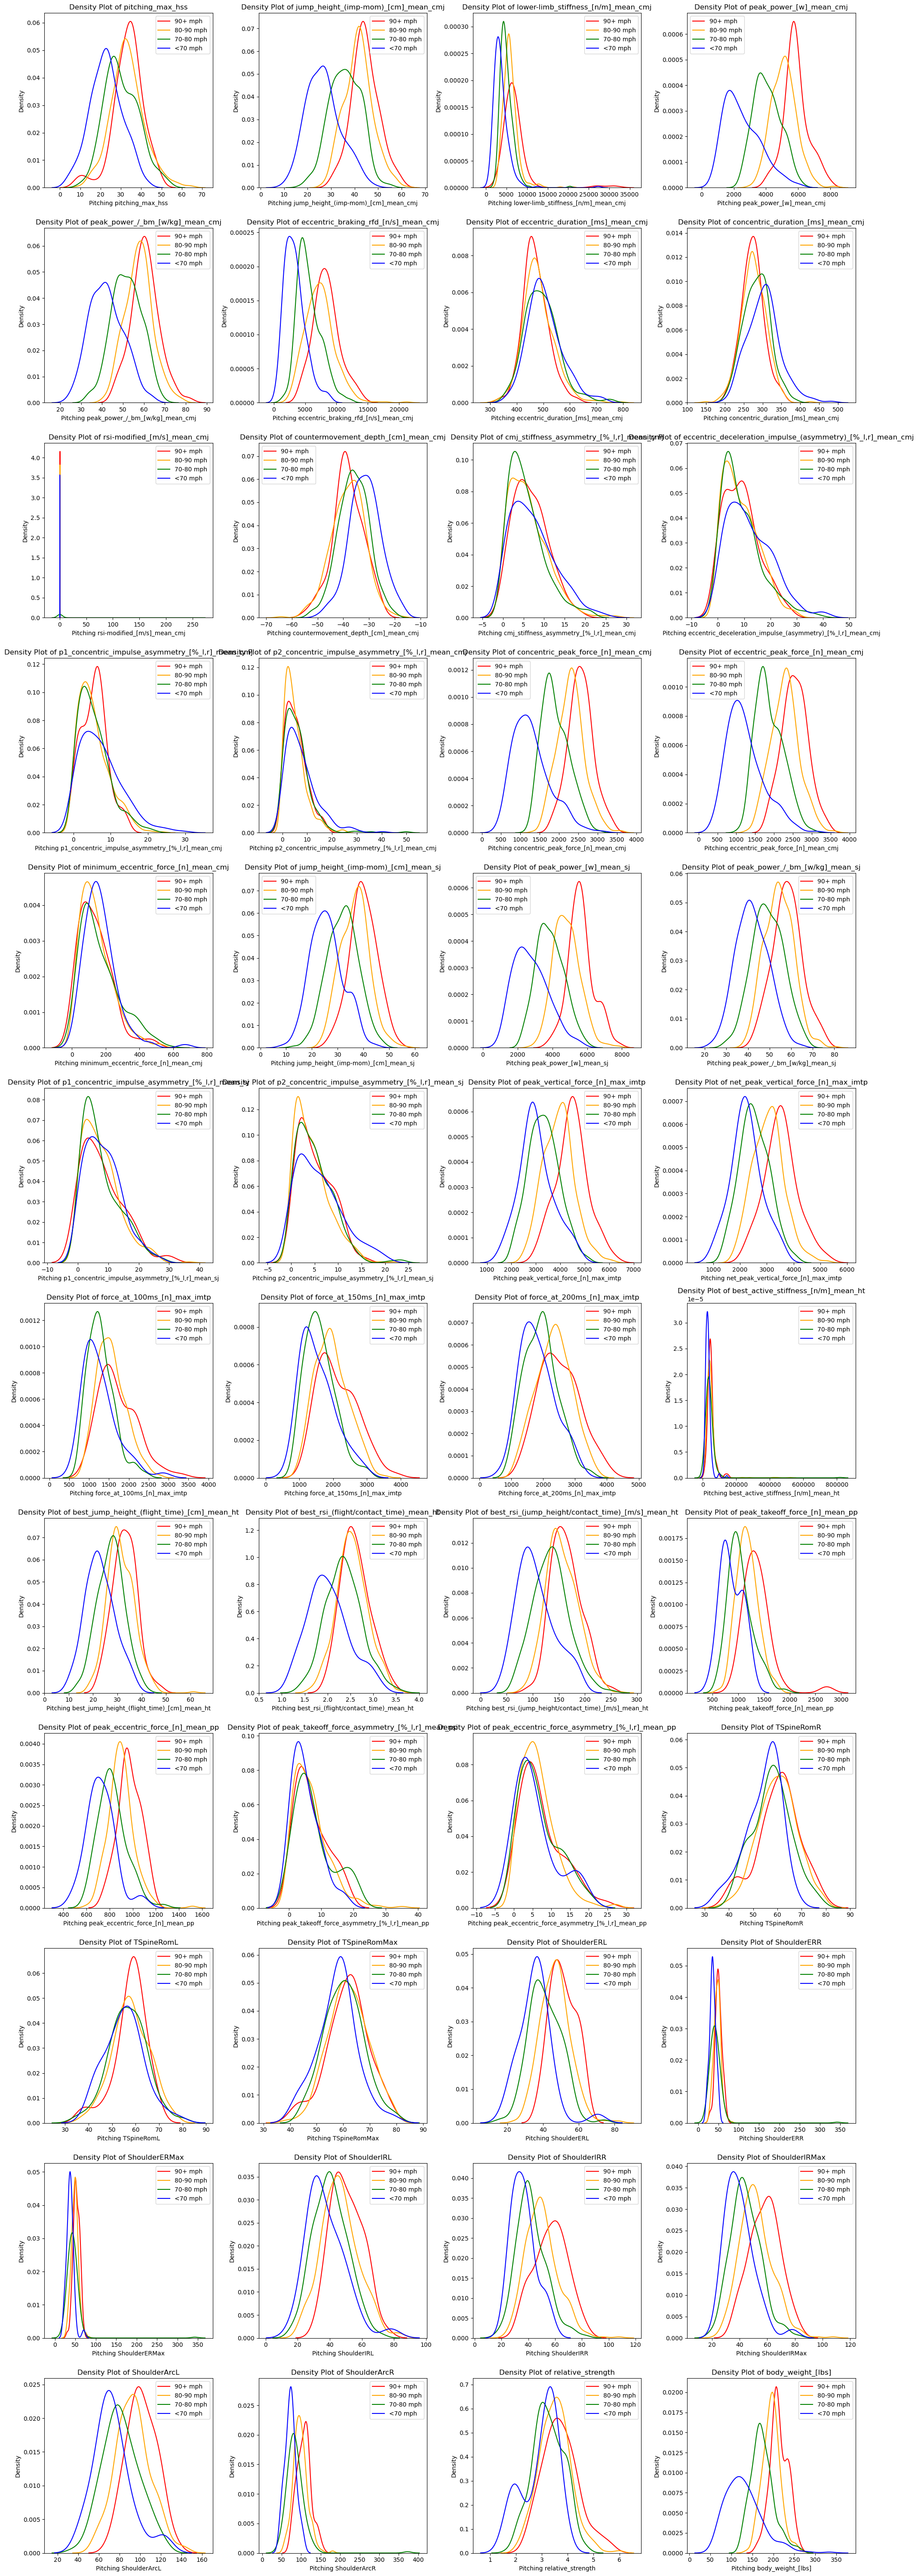

In [41]:
def plot_density_subplots(df_90, df_80, df_70, df_60, variables_to_use):
    num_vars = len(variables_to_use)
    num_cols = 4
    num_rows = (num_vars + num_cols - 1) // num_cols  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for i, var in enumerate(variables_to_use):
        sns.kdeplot(df_90[var], label='90+ mph', color='red', ax=axes[i])
        sns.kdeplot(df_80[var], label='80-90 mph', color='orange', ax=axes[i])
        sns.kdeplot(df_70[var], label='70-80 mph', color='green', ax=axes[i])
        sns.kdeplot(df_60[var], label='<70 mph', color='blue', ax=axes[i])
        axes[i].set_xlabel(f'Pitching {var}')
        axes[i].set_ylabel('Density')
        axes[i].set_title(f'Density Plot of {var}')
        axes[i].legend()
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('Marginal PDF.png')
    plt.show()

plot_density_subplots(df_90, df_80, df_70, df_60, variables_to_use)

In [6]:
def calculate_js_divergence(df_90, df_80, df_70, df_60, variables_to_use):
    js_divergences = {}
    
    for var in variables_to_use:
        # Calculate KDE for each group
        kde_90 = sns.kdeplot(df_90[var]).get_lines()[0].get_data()
        kde_80 = sns.kdeplot(df_80[var]).get_lines()[1].get_data()
        kde_70 = sns.kdeplot(df_70[var]).get_lines()[2].get_data()
        kde_60 = sns.kdeplot(df_60[var]).get_lines()[3].get_data()
        
        # Interpolate KDEs to a common grid
        x_min = min(kde_90[0].min(), kde_80[0].min(), kde_70[0].min(), kde_60[0].min())
        x_max = max(kde_90[0].max(), kde_80[0].max(), kde_70[0].max(), kde_60[0].max())
        x_grid = np.linspace(x_min, x_max, 1000)
        
        kde_90_interp = np.interp(x_grid, kde_90[0], kde_90[1])
        kde_80_interp = np.interp(x_grid, kde_80[0], kde_80[1])
        kde_70_interp = np.interp(x_grid, kde_70[0], kde_70[1])
        kde_60_interp = np.interp(x_grid, kde_60[0], kde_60[1])
        
        # Normalize the KDEs to ensure they sum to 1
        kde_90_interp /= np.trapz(kde_90_interp, x_grid)
        kde_80_interp /= np.trapz(kde_80_interp, x_grid)
        kde_70_interp /= np.trapz(kde_70_interp, x_grid)
        kde_60_interp /= np.trapz(kde_60_interp, x_grid)
        
        # Calculate JS divergence
        js_90_80 = jensenshannon(kde_90_interp, kde_80_interp)
        js_90_70 = jensenshannon(kde_90_interp, kde_70_interp)
        js_90_60 = jensenshannon(kde_90_interp, kde_60_interp)
        js_80_70 = jensenshannon(kde_80_interp, kde_70_interp)
        js_80_60 = jensenshannon(kde_80_interp, kde_60_interp)
        js_70_60 = jensenshannon(kde_70_interp, kde_60_interp)
        
        # Store the results
        js_divergences[var] = {
            '90-80': js_90_80,
            '90-70': js_90_70,
            '90-60': js_90_60,
            '80-70': js_80_70,
            '80-60': js_80_60,
            '70-60': js_70_60
        }
        
        # Clear the current plot
        plt.clf()
    
    return js_divergences

js_divergences = calculate_js_divergence(df_90, df_80, df_70, df_60, variables_to_use)

<Figure size 640x480 with 0 Axes>

In [31]:
def find_top_5_variables(js_divergences):
    # Extract the JS divergence values for the '80-70' key
    js_80_70 = {var: js_divergences[var]['80-70'] for var in js_divergences}
    
    # Sort the variables by JS divergence in descending order
    sorted_js_80_70 = sorted(js_80_70.items(), key=lambda item: item[1], reverse=True)
    
    # Get the top 5 variables
    top_5_variables = sorted_js_80_70[:5]
    
    return sorted_js_80_70

sorted_js_80_70 = find_top_5_variables(js_divergences)

In [32]:
sorted_js_80_70

[('rsi-modified_[m/s]_mean_cmj', 0.7532406793383297),
 ('peak_power_[w]_mean_cmj', 0.40227045710082077),
 ('peak_power_[w]_mean_sj', 0.3897397420143316),
 ('concentric_peak_force_[n]_mean_cmj', 0.3672287589519208),
 ('eccentric_peak_force_[n]_mean_cmj', 0.35876110849829523),
 ('body_weight_[lbs]', 0.3367372466515075),
 ('peak_vertical_force_[n]_max_imtp', 0.3135208132457484),
 ('jump_height_(imp-mom)_[cm]_mean_cmj', 0.2980951613449),
 ('net_peak_vertical_force_[n]_max_imtp', 0.2949209793832631),
 ('peak_power_/_bm_[w/kg]_mean_cmj', 0.2827144619330744),
 ('eccentric_braking_rfd_[n/s]_mean_cmj', 0.2763482678793296),
 ('jump_height_(imp-mom)_[cm]_mean_sj', 0.2750840041015107),
 ('ShoulderArcR', 0.2686914316590531),
 ('force_at_100ms_[n]_max_imtp', 0.26221751391486325),
 ('ShoulderERR', 0.2589182034669053),
 ('peak_power_/_bm_[w/kg]_mean_sj', 0.25363913644249053),
 ('ShoulderERMax', 0.2517390176719939),
 ('peak_eccentric_force_[n]_mean_pp', 0.2516876584665056),
 ('force_at_200ms_[n]_max_im

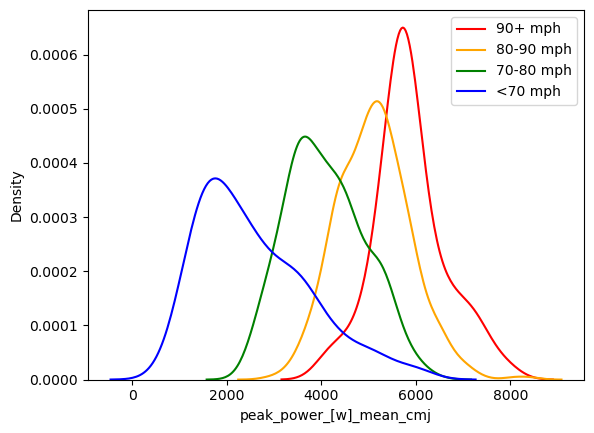

In [66]:
var = 'peak_power_[w]_mean_cmj'
sns.kdeplot(df_90[var], label='90+ mph', color='red')
sns.kdeplot(df_80[var], label='80-90 mph', color='orange')
sns.kdeplot(df_70[var], label='70-80 mph', color='green')
sns.kdeplot(df_60[var], label='<70 mph', color='blue')
plt.legend()
plt.show()

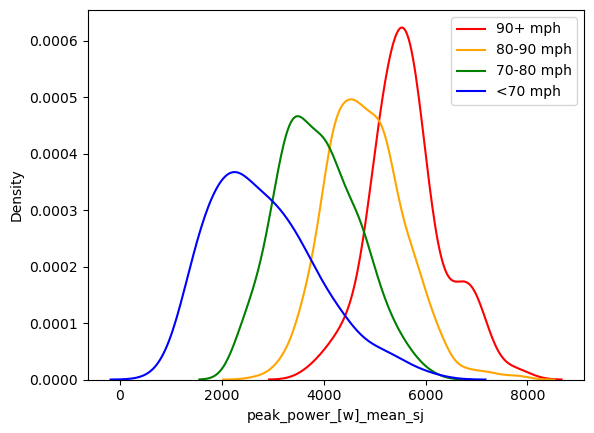

In [71]:
var = 'peak_power_[w]_mean_sj'
sns.kdeplot(df_90[var], label='90+ mph', color='red')
sns.kdeplot(df_80[var], label='80-90 mph', color='orange')
sns.kdeplot(df_70[var], label='70-80 mph', color='green')
sns.kdeplot(df_60[var], label='<70 mph', color='blue')
plt.legend()
plt.show()

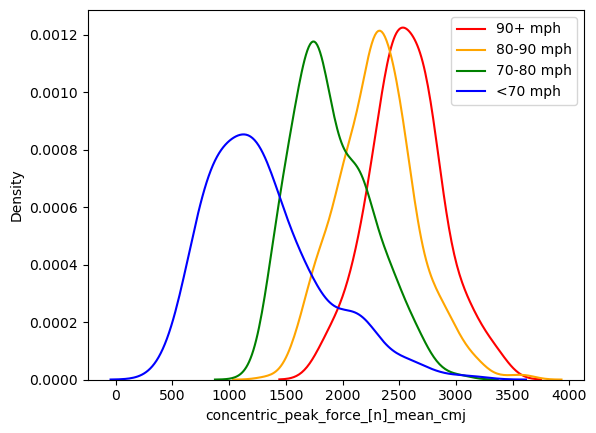

In [67]:
var = 'concentric_peak_force_[n]_mean_cmj'
sns.kdeplot(df_90[var], label='90+ mph', color='red')
sns.kdeplot(df_80[var], label='80-90 mph', color='orange')
sns.kdeplot(df_70[var], label='70-80 mph', color='green')
sns.kdeplot(df_60[var], label='<70 mph', color='blue')
plt.legend()
plt.show()

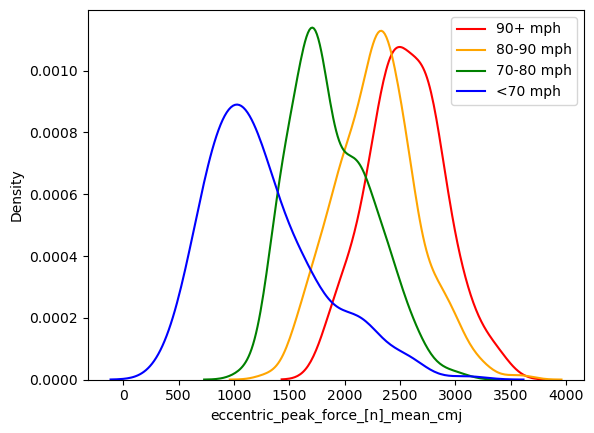

In [73]:
var = 'eccentric_peak_force_[n]_mean_cmj'
sns.kdeplot(df_90[var], label='90+ mph', color='red')
sns.kdeplot(df_80[var], label='80-90 mph', color='orange')
sns.kdeplot(df_70[var], label='70-80 mph', color='green')
sns.kdeplot(df_60[var], label='<70 mph', color='blue')
plt.legend()
plt.show()

In [68]:
def find_bot_5_variables(js_divergences):
    # Extract the JS divergence values for the '80-70' key
    js_80_70 = {var: js_divergences[var]['80-70'] for var in js_divergences}
    
    # Sort the variables by JS divergence in descending order
    sorted_js_80_70 = sorted(js_80_70.items(), key=lambda item: item[1], reverse=False)
    
    # Get the bot 5 variables
    bot_5_variables = sorted_js_80_70[:5]
    
    return bot_5_variables

bot_5_variables = find_bot_5_variables(js_divergences)
print("Bot 5 Variables that Separate 80-70 mph Group:", bot_5_variables)

Bot 5 Variables that Separate 80-70 mph Group: [('p1_concentric_impulse_asymmetry_[%_l,r]_mean_cmj', 0.04548228823261643), ('p1_concentric_impulse_asymmetry_[%_l,r]_mean_sj', 0.07095831881829806), ('cmj_stiffness_asymmetry_[%_l,r]_mean_cmj', 0.07097349061097304), ('p2_concentric_impulse_asymmetry_[%_l,r]_mean_sj', 0.07513063361958656), ('TSpineRomL', 0.08020326547436647)]


### Q: Do people who provide less power have better shoulder IR? How about the opposite?
### A: Not really. No association...

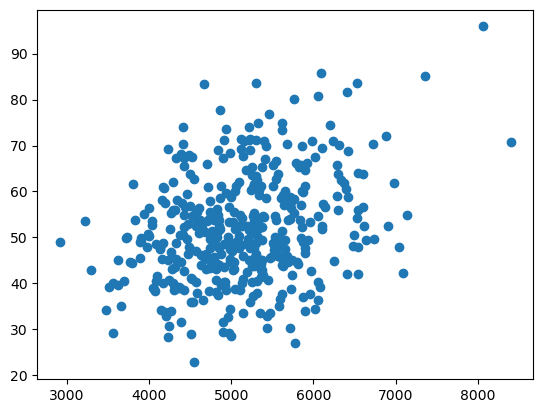

In [8]:
plt.scatter(df_80['peak_power_[w]_mean_cmj'], df_80['ShoulderIRMax'])

## Q: What's special about hard throwers who generate less power?

#### Case I

In [16]:
df_90_outliers = df_90.loc[df_90['peak_power_[w]_mean_cmj'].nsmallest(3).index]

In [17]:
percentiles = {}
for var in variables_to_use:
    percentile = percentileofscore(df[var].dropna(), df_90_outliers.iloc[0][var])
    if not np.isnan(percentile):
        percentiles[var] = percentile

In [18]:
mobility_vars = ['ShoulderERL', 'ShoulderIRL', 'ShoulderArcL', 'ShoulderERR', 'ShoulderIRR',
                'ShoulderArcR', 'ShoulderERMax', 'ShoulderIRMax', 'TSpineRomL', 'TSpineRomR',
                'TSpineRomMax', 'pitching_max_hss']

In [19]:
percentiles = dict(sorted(percentiles.items(), key=lambda item: item[1], reverse=True))
for var in mobility_vars:
    if var in percentiles:
        print(var, ":", percentiles[var])

ShoulderERR : 34.09090909090909
ShoulderIRR : 25.405007363770252
ShoulderArcR : 26.067746686303387
ShoulderERMax : 28.601398601398603
ShoulderIRMax : 19.090909090909093
TSpineRomL : 19.935897435897434
TSpineRomR : 29.321382842509603
TSpineRomMax : 20.93469910371319
pitching_max_hss : 76.6453382084095


In [20]:
for key, value in percentiles.items():
    if value >= 75 or value <= 25:
        print(f'{key}: {value:.1f}%, value={df_90_outliers.iloc[0][key]}')

cmj_stiffness_asymmetry_[%_l,r]_mean_cmj: 89.8%, value=13.06
peak_eccentric_force_asymmetry_[%_l,r]_mean_pp: 87.3%, value=12.23
peak_eccentric_force_[n]_mean_pp: 86.5%, value=1010.61
lower-limb_stiffness_[n/m]_mean_cmj: 82.8%, value=6712.39
eccentric_braking_rfd_[n/s]_mean_cmj: 82.1%, value=8476.21
pitching_max_hss: 76.6%, value=36.4
peak_power_/_bm_[w/kg]_mean_sj: 24.9%, value=45.65
TSpineRomMax: 20.9%, value=55.0
TSpineRomL: 19.9%, value=51.0
ShoulderIRMax: 19.1%, value=39.0
minimum_eccentric_force_[n]_mean_cmj: 17.4%, value=62.02
concentric_duration_[ms]_mean_cmj: 16.9%, value=248.67
p1_concentric_impulse_asymmetry_[%_l,r]_mean_sj: 14.0%, value=1.55
eccentric_duration_[ms]_mean_cmj: 7.1%, value=411.33


- peak_eccentric_force_[n]_mean_pp:     86.2%, value=1010.61 --> **Strong arm!!!**
- lower-limb_stiffness_[n/m]_mean_cmj:  82.9%, value=6712.39 --> ?
- eccentric_braking_rfd_[n/s]_mean_cmj: 82.0%, value=8476.21 --> ?
- pitching_max_hss:                     76.7%, value=36.4    --> Flexible, **good mechanics(?)**
- concentric_duration_[ms]_mean_cmj:    16.8%, value=248.67  --> Can deliver power quickly
- eccentric_duration_[ms]_mean_cmj:      7.1%, value=411.33  --> Can deliver power quickly

#### Case II

In [23]:
percentiles = {}
for var in variables_to_use:
    percentile = percentileofscore(df[var].dropna(), df_90_outliers.iloc[1][var])
    if not np.isnan(percentile):
        percentiles[var] = percentile
percentiles = dict(sorted(percentiles.items(), key=lambda item: item[1], reverse=True))
for var in mobility_vars:
    if var in percentiles:
        print(var, ":", percentiles[var])

ShoulderERL : 28.98989898989899
ShoulderIRL : 38.71951219512195
ShoulderArcL : 31.504065040650406
ShoulderERR : 29.105571847507335
ShoulderIRR : 15.243004418262151
ShoulderArcR : 18.262150220913107
ShoulderERMax : 24.405594405594407
ShoulderIRMax : 24.685314685314687
TSpineRomL : 58.52564102564102
TSpineRomR : 80.72983354673495
TSpineRomMax : 74.26376440460947
pitching_max_hss : 64.03107861060329


In [25]:
for key, value in percentiles.items():
    if value >= 75 or value <= 25:
        print(f'{key}: {value:.1f}%, value={df_90_outliers.iloc[1][key]}')

best_jump_height_(flight_time)_[cm]_mean_ht: 95.4%, value=39.27
p2_concentric_impulse_asymmetry_[%_l,r]_mean_cmj: 95.0%, value=15.7
best_rsi_(jump_height/contact_time)_[m/s]_mean_ht: 92.9%, value=198.62
best_rsi_(flight/contact_time)_mean_ht: 90.8%, value=2.96
p1_concentric_impulse_asymmetry_[%_l,r]_mean_cmj: 83.8%, value=10.06
TSpineRomR: 80.7%, value=66.0
peak_power_/_bm_[w/kg]_mean_sj: 80.2%, value=58.53
p2_concentric_impulse_asymmetry_[%_l,r]_mean_sj: 79.4%, value=8.18
relative_strength: 78.6%, value=3.92
peak_eccentric_force_asymmetry_[%_l,r]_mean_pp: 76.0%, value=9.1
ShoulderIRMax: 24.7%, value=40.8
ShoulderERMax: 24.4%, value=40.6
peak_takeoff_force_[n]_mean_pp: 20.4%, value=934.71
peak_eccentric_force_[n]_mean_pp: 20.2%, value=775.96
ShoulderArcR: 18.3%, value=76.4
p1_concentric_impulse_asymmetry_[%_l,r]_mean_sj: 15.9%, value=1.78
ShoulderIRR: 15.2%, value=35.8
force_at_100ms_[n]_max_imtp: 15.1%, value=1071.49
countermovement_depth_[cm]_mean_cmj: 14.6%, value=-43.12
minimum_ecc

 - best_jump_height_(flight_time)_[cm]_mean_ht: 95.4%, value=39.27
 - best_rsi_(jump_height/contact_time)_[m/s]_mean_ht: 92.9%, value=198.62
 - peak_power_/_bm_[w/kg]_mean_sj: 80.2%, value=58.53
 - **Not powerful due to light weight. Athlete has muscle**
 - TSpineRomR: 80.7%, value=66.0
 - ShoulderIRMax: 24.7%, value=40.8
 - ShoulderERMax: 24.4%, value=40.6
 - **Good TSpine mobility, but interestingly, bad shoulder mobility**

#### Case III

In [26]:
percentiles = {}
for var in variables_to_use:
    percentile = percentileofscore(df[var].dropna(), df_90_outliers.iloc[2][var])
    if not np.isnan(percentile):
        percentiles[var] = percentile
percentiles = dict(sorted(percentiles.items(), key=lambda item: item[1], reverse=True))
for var in mobility_vars:
    if var in percentiles:
        print(var, ":", percentiles[var])

ShoulderERL : 36.26262626262626
ShoulderIRL : 41.5650406504065
ShoulderArcL : 38.82113821138211
ShoulderERR : 33.72434017595308
ShoulderIRR : 11.119293078055964
ShoulderArcR : 16.494845360824744
ShoulderERMax : 27.972027972027973
ShoulderIRMax : 26.573426573426577
TSpineRomL : 72.5
TSpineRomR : 68.11779769526248
TSpineRomMax : 60.05121638924456
pitching_max_hss : 89.39670932358318


In [28]:
for key, value in percentiles.items():
    if value >= 75 or value <= 25:
        print(f'{key}: {value:.1f}%, value={df_90_outliers.iloc[2][key]}')

pitching_max_hss: 89.4%, value=41.1
p1_concentric_impulse_asymmetry_[%_l,r]_mean_sj: 85.7%, value=14.7
eccentric_braking_rfd_[n/s]_mean_cmj: 81.4%, value=8401.94
lower-limb_stiffness_[n/m]_mean_cmj: 79.8%, value=6518.61
force_at_150ms_[n]_max_imtp: 77.8%, value=2243.2
force_at_200ms_[n]_max_imtp: 75.7%, value=2619.9
body_weight_[lbs]: 75.6%, value=204.12
force_at_100ms_[n]_max_imtp: 75.2%, value=1707.1
peak_power_/_bm_[w/kg]_mean_sj: 23.1%, value=45.11
ShoulderArcR: 16.5%, value=75.1
eccentric_deceleration_impulse_(asymmetry)_[%_l,r]_mean_cmj: 15.5%, value=2.17
ShoulderIRR: 11.1%, value=33.5
minimum_eccentric_force_[n]_mean_cmj: 8.7%, value=40.12


 - pitching_max_hss: 89.4%, value=41.1
 - Avg/below avg tspineROM & shoulder ROM
 - **Good mechanics to have good HSS**
 - eccentric_braking_rfd_[n/s]_mean_cmj: 81.4%, value=8401.94
 - lower-limb_stiffness_[n/m]_mean_cmj: 79.8%, value=6518.61
 - **Good at landing**

## Q: What's "wrong" with lower velo thrower who could generate high power?
## A: Low HSS (low mobility?), extremely asymetrical muscle

In [46]:
df_60_outliers = df_60.loc[df_60['peak_power_[w]_mean_cmj'].nlargest(3).index]

#### Case I:

In [48]:
percentiles = {}
for var in variables_to_use:
    percentile = percentileofscore(df[var].dropna(), df_60_outliers.iloc[0][var])
    if not np.isnan(percentile):
        percentiles[var] = percentile

In [50]:
percentiles = dict(sorted(percentiles.items(), key=lambda item: item[1], reverse=True))
for var in mobility_vars:
    if var in percentiles:
        print(var, ":", percentiles[var])

pitching_max_hss : 25.776965265082268


In [53]:
for key, value in percentiles.items():
    if value >= 75 or value <= 30:
        print(f'{key}: {value:.1f}%, value={df_60_outliers.iloc[0][key]}')

p1_concentric_impulse_asymmetry_[%_l,r]_mean_sj: 99.0%, value=25.45
p1_concentric_impulse_asymmetry_[%_l,r]_mean_cmj: 98.7%, value=18.96
cmj_stiffness_asymmetry_[%_l,r]_mean_cmj: 98.6%, value=19.79
p2_concentric_impulse_asymmetry_[%_l,r]_mean_sj: 97.3%, value=14.06
eccentric_deceleration_impulse_(asymmetry)_[%_l,r]_mean_cmj: 95.6%, value=24.26
peak_power_[w]_mean_cmj: 92.6%, value=6049.13
peak_power_[w]_mean_sj: 89.7%, value=5662.24
peak_power_/_bm_[w/kg]_mean_cmj: 88.6%, value=63.03
eccentric_peak_force_[n]_mean_cmj: 87.4%, value=2591.47
concentric_peak_force_[n]_mean_cmj: 85.8%, value=2564.98
peak_vertical_force_[n]_max_imtp: 84.6%, value=4445.8
body_weight_[lbs]: 83.9%, value=211.16
force_at_200ms_[n]_max_imtp: 83.7%, value=2832.4
jump_height_(imp-mom)_[cm]_mean_cmj: 83.7%, value=45.08
net_peak_vertical_force_[n]_max_imtp: 83.2%, value=3507.11
peak_power_/_bm_[w/kg]_mean_sj: 81.0%, value=59.0
eccentric_braking_rfd_[n/s]_mean_cmj: 79.3%, value=8228.73
force_at_150ms_[n]_max_imtp: 78.

 - pitching_max_hss: 25.8%, value=24.5 --> Bad mobility (no other mobility data to confirm...), bad mechanics
 - p1_concentric_impulse_asymmetry_[%_l,r]_mean_sj: 99.0%, value=25.45
 - p1_concentric_impulse_asymmetry_[%_l,r]_mean_cmj: 98.7%, value=18.96
 - cmj_stiffness_asymmetry_[%_l,r]_mean_cmj: 98.6%, value=19.79
 - p2_concentric_impulse_asymmetry_[%_l,r]_mean_sj: 97.3%, value=14.06
 - eccentric_deceleration_impulse_(asymmetry)_[%_l,r]_mean_cmj: 95.6%, value=24.26
 - **EXTREMELY** asymmetrical muscle

#### Case II

In [69]:
percentiles = {}
for var in variables_to_use:
    percentile = percentileofscore(df[var].dropna(), df_60_outliers.iloc[1][var])
    if not np.isnan(percentile):
        percentiles[var] = percentile
percentiles = dict(sorted(percentiles.items(), key=lambda item: item[1], reverse=True))
for var in mobility_vars:
    if var in percentiles:
        print(var, ":", percentiles[var])

ShoulderERL : 99.19191919191918
ShoulderIRL : 76.11788617886178
ShoulderArcL : 96.34146341463415
ShoulderERR : 68.6950146627566
ShoulderIRR : 65.90574374079529
ShoulderArcR : 69.58762886597938
ShoulderERMax : 98.74125874125875
ShoulderIRMax : 60.909090909090914
TSpineRomL : 4.358974358974359
TSpineRomR : 6.530089628681178
TSpineRomMax : 2.816901408450704
pitching_max_hss : 15.12797074954296


In [71]:
for key, value in percentiles.items():
    if value >= 75 or value <= 25:
        print(f'{key}: {value:.1f}%, value={df_60_outliers.iloc[1][key]}')

force_at_100ms_[n]_max_imtp: 99.8%, value=2857.22
body_weight_[lbs]: 99.6%, value=265.21
ShoulderERL: 99.2%, value=70.5
minimum_eccentric_force_[n]_mean_cmj: 98.8%, value=475.79
ShoulderERMax: 98.7%, value=70.5
force_at_150ms_[n]_max_imtp: 96.9%, value=2934.72
ShoulderArcL: 96.3%, value=122.8
force_at_200ms_[n]_max_imtp: 93.8%, value=3142.22
peak_power_[w]_mean_cmj: 91.7%, value=5968.66
eccentric_duration_[ms]_mean_cmj: 89.2%, value=562.5
concentric_peak_force_[n]_mean_cmj: 87.6%, value=2593.79
concentric_duration_[ms]_mean_cmj: 82.5%, value=316.0
eccentric_peak_force_[n]_mean_cmj: 81.1%, value=2476.04
ShoulderIRL: 76.1%, value=52.3
best_jump_height_(flight_time)_[cm]_mean_ht: 18.9%, value=23.3
rsi-modified_[m/s]_mean_cmj: 18.9%, value=0.41
jump_height_(imp-mom)_[cm]_mean_sj: 15.3%, value=26.45
pitching_max_hss: 15.1%, value=21.4
p2_concentric_impulse_asymmetry_[%_l,r]_mean_sj: 14.1%, value=0.94
best_active_stiffness_[n/m]_mean_ht: 10.4%, value=23310.77
p2_concentric_impulse_asymmetry_

 - eccentric_duration_[ms]_mean_cmj: 89.2%, value=562.5
 - concentric_duration_[ms]_mean_cmj: 82.5%, value=316.0
 - best_jump_height_(flight_time)_[cm]_mean_ht: 18.9%, value=23.3
 - peak_power_/_bm_[w/kg]_mean_sj: 3.0%, value=34.22
1. Power generated by mass (peak_power/bm), not muscle
 - pitching_max_hss: 15.1%, value=21.4
 - TSpineRomMax: 2.8%, value=46.0
 - TSpineRomR: 6.5%, value=46.0
 - TSpineRomL: 4.4%, value=43.0
2. EXTREMELY poor TSpine mobility (although GREAT shoulder mobility)

#### Case III

In [72]:
percentiles = {}
for var in variables_to_use:
    percentile = percentileofscore(df[var].dropna(), df_60_outliers.iloc[2][var])
    if not np.isnan(percentile):
        percentiles[var] = percentile
percentiles = dict(sorted(percentiles.items(), key=lambda item: item[1], reverse=True))
for var in mobility_vars:
    if var in percentiles:
        print(var, ":", percentiles[var])

ShoulderERL : 33.93939393939394
ShoulderIRL : 88.21138211382113
ShoulderArcL : 71.54471544715447
ShoulderERR : 21.700879765395896
ShoulderIRR : 70.10309278350516
ShoulderArcR : 47.20176730486009
ShoulderERMax : 25.944055944055947
ShoulderIRMax : 77.62237762237763
TSpineRomL : 52.43589743589743
TSpineRomR : 9.154929577464788
TSpineRomMax : 32.90653008962868
pitching_max_hss : 10.054844606946983


In [73]:
for key, value in percentiles.items():
    if value >= 75 or value <= 25:
        print(f'{key}: {value:.1f}%, value={df_60_outliers.iloc[2][key]}')

body_weight_[lbs]: 100.0%, value=332.88
minimum_eccentric_force_[n]_mean_cmj: 99.9%, value=651.55
concentric_peak_force_[n]_mean_cmj: 98.8%, value=3114.08
eccentric_peak_force_[n]_mean_cmj: 98.8%, value=3104.03
eccentric_duration_[ms]_mean_cmj: 98.0%, value=643.75
concentric_duration_[ms]_mean_cmj: 96.6%, value=354.25
p1_concentric_impulse_asymmetry_[%_l,r]_mean_sj: 94.8%, value=19.12
eccentric_deceleration_impulse_(asymmetry)_[%_l,r]_mean_cmj: 91.5%, value=20.84
p2_concentric_impulse_asymmetry_[%_l,r]_mean_sj: 90.8%, value=10.43
force_at_100ms_[n]_max_imtp: 90.5%, value=2056.0
peak_vertical_force_[n]_max_imtp: 88.3%, value=4599.3
ShoulderIRL: 88.2%, value=58.7
peak_power_[w]_mean_cmj: 88.2%, value=5795.9
force_at_150ms_[n]_max_imtp: 85.2%, value=2428.4
peak_power_[w]_mean_sj: 85.0%, value=5441.3
force_at_200ms_[n]_max_imtp: 78.7%, value=2695.5
lower-limb_stiffness_[n/m]_mean_cmj: 78.6%, value=6453.66
ShoulderIRMax: 77.6%, value=58.7
ShoulderERR: 21.7%, value=38.0
jump_height_(imp-mom)

 - eccentric_duration_[ms]_mean_cmj: 89.2%, value=562.5
 - concentric_duration_[ms]_mean_cmj: 82.5%, value=316.0
 - best_jump_height_(flight_time)_[cm]_mean_ht: 18.9%, value=23.3
 - peak_power_/_bm_[w/kg]_mean_sj: 3.0%, value=34.22
1. Power generated by mass (peak_power/bm), not muscle
 - pitching_max_hss: 15.1%, value=21.4
 - TSpineRomMax: 2.8%, value=46.0
 - TSpineRomR: 6.5%, value=46.0
 - TSpineRomL: 4.4%, value=43.0
2. EXTREMELY poor TSpine mobility (although GREAT shoulder mobility)

# Mechanics

In [37]:
df_mech = pd.read_csv('baseball_pitching/data/poi/poi_metrics.csv')
df_mech = df_mech[df_mech['pitch_speed_mph'] >= 20].dropna()

## Basic Info Histogram

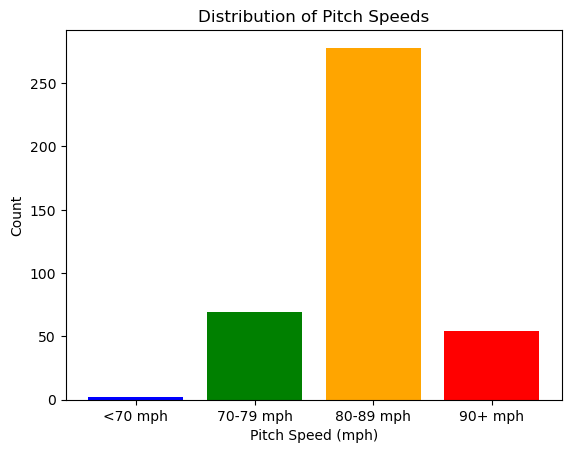

In [42]:
counts = [len(df_mech_60), len(df_mech_70), len(df_mech_80), len(df_mech_90)]
labels = ['<70 mph', '70-79 mph', '80-89 mph', '90+ mph']
plt.bar(labels, counts, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Pitch Speed (mph)')
plt.ylabel('Count')
plt.title('Distribution of Pitch Speeds')
plt.show()

## Add Efficiency Matrics

In [38]:
# Add height/weight

base_dir = 'baseball_pitching/data/c3d'

df_mech['weight'] = df_mech['session'] * 5000
df_mech['height'] = df_mech['session'] * 5000

for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.c3d'):
                parts = file_name.split('_')
                if parts[-1] == 'model.c3d':
                    continue
                
                session_pitch = parts[1].lstrip("0") + '_' + parts[4].lstrip("0")
                height, weight = int(parts[2]), int(parts[3])
                
                # Check if session_pitch exists in df_mech
                if session_pitch in df_mech['session_pitch'].values:
                    # Update height and weight
                    df_mech.loc[df_mech['session_pitch'] == session_pitch, 'height'] = height
                    df_mech.loc[df_mech['session_pitch'] == session_pitch, 'weight'] = weight

# set negative if dne
df_mech.loc[df_mech['weight'] > 1000, ['weight', 'height']] = -1

In [39]:
df_mech['cog_KE'] = np.where(df_mech['weight'] == -1, -1, df_mech['weight'] * df_mech['cog_velo_pkh'])
df_mech['velo_to_cog_KE'] = np.where(df_mech['cog_KE'] <= 0, -1, df_mech['pitch_speed_mph'] / df_mech['cog_KE'])

In [40]:
df_mech_90 = df_mech[df_mech['pitch_speed_mph'] >= 90]
df_mech_85_90 = df_mech[(df_mech['pitch_speed_mph'] >= 85) & (df_mech['pitch_speed_mph'] < 90)]
df_mech_80_85 = df_mech[(df_mech['pitch_speed_mph'] >= 80) & (df_mech['pitch_speed_mph'] < 85)]
df_mech_75_80 = df_mech[(df_mech['pitch_speed_mph'] >= 75) & (df_mech['pitch_speed_mph'] < 80)]

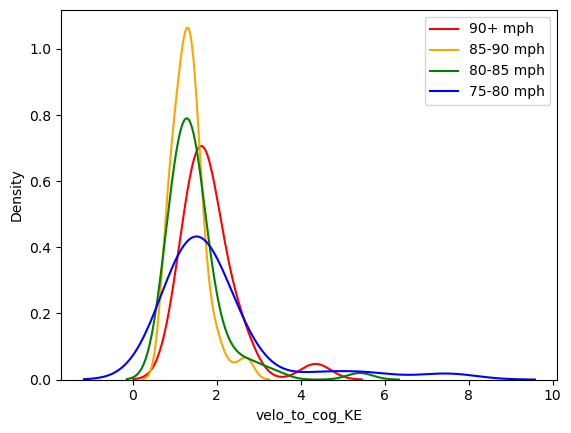

In [41]:
var = 'velo_to_cog_KE'
a = df_mech_90[df_mech_90[var] > 0]
b = df_mech_85_90[df_mech_85_90[var] > 0]
c = df_mech_80_85[df_mech_80_85[var] > 0]
d = df_mech_75_80[df_mech_75_80[var] > 0]
sns.kdeplot(a[var], label='90+ mph', color='red')
sns.kdeplot(b[var], label='85-90 mph', color='orange')
sns.kdeplot(c[var], label='80-85 mph', color='green')
sns.kdeplot(d[var], label='75-80 mph', color='blue')
plt.legend()
plt.show()

In [42]:
variables_to_use = [
       'max_shoulder_internal_rotational_velo', 'max_elbow_extension_velo',
       'max_torso_rotational_velo', 'max_rotation_hip_shoulder_separation',
       'max_elbow_flexion', 'max_shoulder_external_rotation',
       'elbow_flexion_fp', 'elbow_pronation_fp',
       'rotation_hip_shoulder_separation_fp',
       'shoulder_horizontal_abduction_fp', 'shoulder_abduction_fp',
       'shoulder_external_rotation_fp', 'lead_knee_extension_angular_velo_fp',
       'lead_knee_extension_angular_velo_br',
       'lead_knee_extension_angular_velo_max', 'torso_anterior_tilt_fp',
       'torso_lateral_tilt_fp', 'torso_rotation_fp', 'pelvis_anterior_tilt_fp',
       'pelvis_lateral_tilt_fp', 'pelvis_rotation_fp', 'max_cog_velo_x',
       'torso_rotation_min', 'max_pelvis_rotational_velo',
       'glove_shoulder_horizontal_abduction_fp', 'glove_shoulder_abduction_fp',
       'glove_shoulder_external_rotation_fp', 'glove_shoulder_abduction_mer',
       'elbow_flexion_mer', 'torso_anterior_tilt_mer',
       'torso_lateral_tilt_mer', 'torso_rotation_mer', 'elbow_varus_moment',
       'shoulder_internal_rotation_moment', 'torso_anterior_tilt_br',
       'torso_lateral_tilt_br', 'torso_rotation_br',
       'lead_knee_extension_from_fp_to_br', 'cog_velo_pkh', 'stride_length',
       'stride_angle', 'arm_slot', 'timing_peak_torso_to_peak_pelvis_rot_velo',
       'max_shoulder_horizontal_abduction', 'shoulder_transfer_fp_br',
       'shoulder_generation_fp_br', 'shoulder_absorption_fp_br',
       'elbow_transfer_fp_br', 'elbow_generation_fp_br',
       'elbow_absorption_fp_br', 'lead_hip_transfer_fp_br',
       'lead_hip_generation_fp_br', 'lead_hip_absorption_fp_br',
       'lead_knee_transfer_fp_br', 'lead_knee_generation_fp_br',
       'lead_knee_absorption_fp_br', 'rear_hip_transfer_pkh_fp',
       'rear_hip_generation_pkh_fp', 'rear_hip_absorption_pkh_fp',
       'rear_knee_transfer_pkh_fp', 'rear_knee_generation_pkh_fp',
       'rear_knee_absorption_pkh_fp', 'pelvis_lumbar_transfer_fp_br',
       'thorax_distal_transfer_fp_br', 'rear_grf_x_max', 'rear_grf_y_max',
       'rear_grf_z_max', 'rear_grf_mag_max', 'rear_grf_angle_at_max',
       'lead_grf_x_max', 'lead_grf_y_max', 'lead_grf_z_max',
       'lead_grf_mag_max', 'lead_grf_angle_at_max', 'peak_rfd_rear',
       'peak_rfd_lead', 'weight', 'height', 'cog_KE', 'velo_to_cog_KE']

In [48]:
pd.set_option('display.max_rows', None)
df_mech[variables_to_use+['pitch_speed_mph']].corr()['pitch_speed_mph'].drop('pitch_speed_mph').sort_values(ascending=False)[:]

elbow_transfer_fp_br                         0.682210
shoulder_transfer_fp_br                      0.642701
thorax_distal_transfer_fp_br                 0.636098
shoulder_internal_rotation_moment            0.516925
elbow_varus_moment                           0.460446
lead_grf_mag_max                             0.420398
lead_grf_z_max                               0.400618
shoulder_horizontal_abduction_fp             0.378294
max_shoulder_horizontal_abduction            0.338802
lead_grf_x_max                               0.331858
max_shoulder_external_rotation               0.331665
max_shoulder_internal_rotational_velo        0.325236
max_torso_rotational_velo                    0.320079
rotation_hip_shoulder_separation_fp          0.310999
rear_grf_x_max                               0.310397
elbow_absorption_fp_br                       0.304464
max_rotation_hip_shoulder_separation         0.291260
rear_grf_mag_max                             0.273535
shoulder_generation_fp_br   

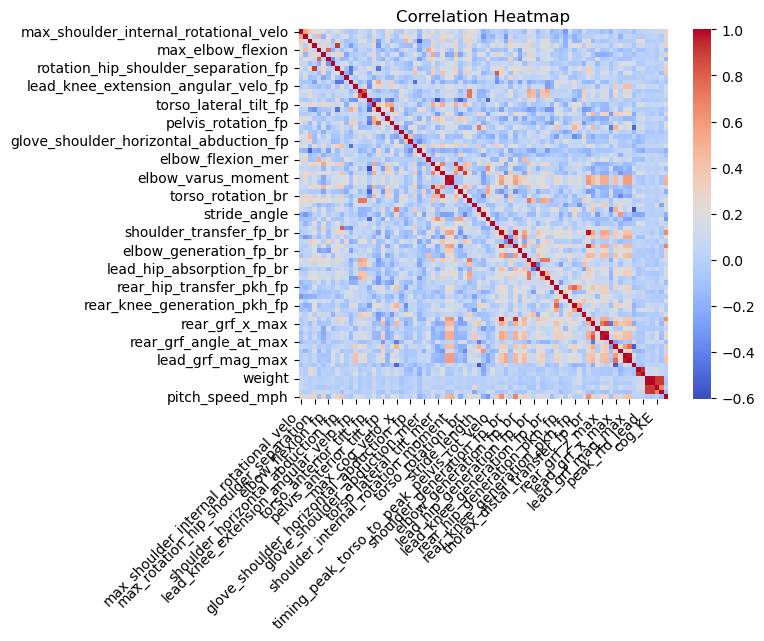

In [55]:
corr_matrix = df_mech[variables_to_use+['pitch_speed_mph']].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', square=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Heatmap')
plt.show()

In [61]:
# Extract the upper triangle of the correlation matrix, excluding the diagonal
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Convert to a long format and drop NaN values
corr_pairs = upper_triangle.stack().reset_index()
corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Sort by the absolute value of the correlation
corr_pairs['AbsCorrelation'] = corr_pairs['Correlation'].abs()
sorted_corr_pairs = corr_pairs.sort_values(by='AbsCorrelation', ascending=False).drop(columns='AbsCorrelation')

# Select the top n correlated pairs
n = 10  # Change this to the desired number of top correlated pairs
top_n_corr_pairs = sorted_corr_pairs.head(n)

print("Top n correlated variable pairs:\n", top_n_corr_pairs)

Top n correlated variable pairs:
                     Variable1                          Variable2  Correlation
3230                   weight                             height     0.990588
2064       elbow_varus_moment  shoulder_internal_rotation_moment     0.978517
2592  shoulder_transfer_fp_br       thorax_distal_transfer_fp_br     0.976657
3135           rear_grf_z_max                   rear_grf_mag_max     0.970783
3195           lead_grf_z_max                   lead_grf_mag_max     0.969368
2576  shoulder_transfer_fp_br               elbow_transfer_fp_br     0.957390
1918  torso_anterior_tilt_mer             torso_anterior_tilt_br     0.936203
3219            peak_rfd_rear                      peak_rfd_lead     0.930495
2694     elbow_transfer_fp_br       thorax_distal_transfer_fp_br     0.925816
1969   torso_lateral_tilt_mer              torso_lateral_tilt_br     0.921563


In [62]:
sorted_corr_pairs

Variable1  \
3230                                     weight   
2064                         elbow_varus_moment   
2592                    shoulder_transfer_fp_br   
3135                             rear_grf_z_max   
3195                             lead_grf_z_max   
2576                    shoulder_transfer_fp_br   
1918                    torso_anterior_tilt_mer   
3219                              peak_rfd_rear   
2694                       elbow_transfer_fp_br   
1969                     torso_lateral_tilt_mer   
3235                                     height   
3231                                     weight   
241        max_rotation_hip_shoulder_separation   
3234                                     height   
3232                                     weight   
2019                         torso_rotation_mer   
3106                             rear_grf_x_max   
1226                          torso_rotation_fp   
962         lead_knee_extension_angular_velo_br   
717            shoulder_horizontal_abduction_fp   
315                           max_elbow_flexion   
2943                   rear_hip_transfer_pkh_fp   
3176                             lead_grf_x_max   
1487                             max_cog_velo_x   
2306          lead_knee_extension_from_fp_to_br   
985         lead_knee_extension_angular_velo_br   
1051       lead_knee_extension_angular_velo_max   
2777                    lead_hip_transfer_fp_br   
3105                             rear_grf_x_max   
2778                    lead_hip_transfer_fp_br   
3237                                     cog_KE   
2711                       elbow_transfer_fp_br   
1915                    torso_anterior_tilt_mer   
1975                     torso_lateral_tilt_mer   
2613                  shoulder_generation_fp_br   
2609                    shoulder_transfer_fp_br   
3103               thorax_distal_transfer_fp_br   
2942                   rear_hip_transfer_pkh_fp   
2141          shoulder_internal_rotation_moment   
2017                         torso_rotation_mer   
2449                               stride_angle   
1109                     torso_anterior_tilt_fp   
3175                             lead_grf_x_max   
2094                         elbow_varus_moment   
2150          shoulder_internal_rotation_moment   
2125          shoulder_internal_rotation_moment   
2149          shoulder_internal_rotation_moment   
2103                         elbow_varus_moment   
2102                         elbow_varus_moment   
2680                       elbow_transfer_fp_br   
2122          shoulder_internal_rotation_moment   
3030                rear_knee_generation_pkh_fp   
998         lead_knee_extension_angular_velo_br   
2309          lead_knee_extension_from_fp_to_br   
0         max_shoulder_internal_rotational_velo   
2412                              stride_length   
413              max_shoulder_external_rotation   
2210                      torso_lateral_tilt_br   
3177                             lead_grf_x_max   
1172                      torso_lateral_tilt_fp   
2078                         elbow_varus_moment   
1163                      torso_lateral_tilt_fp   
2596                    shoulder_transfer_fp_br   
2075                         elbow_varus_moment   
337                           max_elbow_flexion   
2635                  shoulder_generation_fp_br   
2165                     torso_anterior_tilt_br   
1002        lead_knee_extension_angular_velo_br   
2595                    shoulder_transfer_fp_br   
2578                    shoulder_transfer_fp_br   
830               shoulder_external_rotation_fp   
2593                    shoulder_transfer_fp_br   
3108                             rear_grf_x_max   
2636                  shoulder_generation_fp_br   
2944                   rear_hip_transfer_pkh_fp   
3090               thorax_distal_transfer_fp_br   
3089               thorax_distal_transfer_fp_br   
1162                      torso_lateral_tilt_fp   
2158     

In [65]:
corr_matrix['max_rotation_hip_shoulder_separation'].sort_values(ascending=False)

max_rotation_hip_shoulder_separation         1.000000
rotation_hip_shoulder_separation_fp          0.910439
torso_anterior_tilt_mer                      0.326341
lead_hip_transfer_fp_br                      0.309343
torso_anterior_tilt_br                       0.299657
pitch_speed_mph                              0.291260
max_torso_rotational_velo                    0.283768
thorax_distal_transfer_fp_br                 0.280866
max_shoulder_external_rotation               0.279714
lead_knee_extension_from_fp_to_br            0.261462
shoulder_absorption_fp_br                    0.257311
rear_knee_absorption_pkh_fp                  0.249831
max_shoulder_internal_rotational_velo        0.234633
shoulder_transfer_fp_br                      0.228389
torso_lateral_tilt_fp                        0.222235
timing_peak_torso_to_peak_pelvis_rot_velo    0.222158
rear_hip_transfer_pkh_fp                     0.221996
glove_shoulder_abduction_fp                  0.216163
elbow_transfer_fp_br        